## We consider a sinusoidal transverse periodic external field

Trial: Bessel function type of root

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import jn, yn, jn_zeros, yn_zeros, iv, kv
from scipy.special import spherical_jn, spherical_yn

# Set up plotting parameters
plt.rcParams.update({"figure.figsize": (12, 8), "text.usetex": True, "font.size": 12})

print("=== BESSEL FUNCTION ZEROS (First 10) ===")
print("\n1. J_0(x) zeros (most important for freezing):")
j0_zeros = jn_zeros(0, 10)
print("   ", j0_zeros)

=== BESSEL FUNCTION ZEROS (First 10) ===

1. J_0(x) zeros (most important for freezing):
    [ 2.40482556  5.52007811  8.65372791 11.79153444 14.93091771 18.07106397
 21.21163663 24.35247153 27.49347913 30.63460647]


In [3]:
from qutip import *
import numpy as np
from itertools import combinations
from scipy.special import jn_zeros

# helper: operator at one site
def spin_only_op(op, site, N):
    ops = [qeye(2) for _ in range(N)]
    ops[site] = op
    return tensor(*ops)

def g_t(t, args):
    g0 = args['g0']
    w = args['omega']
    return g0 * np.sin(w * t)

def gdot_t(t, args):
    g0 = args['g0']
    w = args['omega']
    return g0 * w * np.cos(w * t)

def coeff(t, args):
    return (g_t(t, args) - gdot_t(t, args)) / np.sqrt(N)


def j_ij(Jvalue, i,j, beta):
    return Jvalue/(np.abs(i-j))**beta

def h0_ham(N, beta, Jvalue):
    sx,sy,sz = sigmax(), sigmay(), sigmaz()
    empt = qzero(2**N) + 1j * qzero(2**N)    
    H0  =  empt
    
    comb = combinations(np.arange(N), 2)
    for nm in list(comb):
        i,j= np.array(nm)
        id = qeye(2**i)
        dim11 = j-i-1
        id1 = qeye(2**dim11)
        dim12 = N-1-j
        id2 = qeye(2**dim12)
        H0 = H0 + Qobj(tensor(id, tensor(sz, tensor(id1, tensor(sz,id2)))).full()) * j_ij(Jvalue, i,j, beta)

    return H0

print("Function defined !")

Function defined !


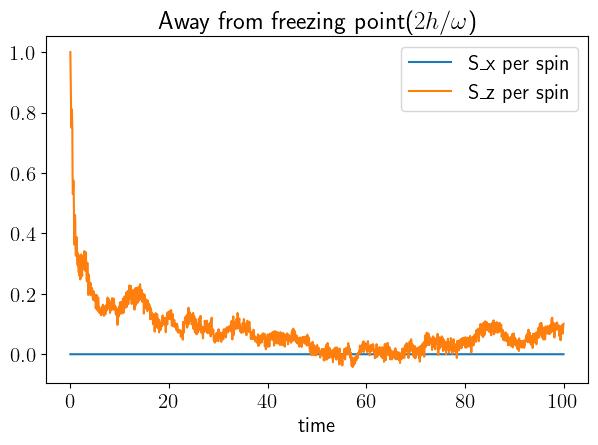

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from qutip import tensor, qeye, destroy, basis, sigmax, sesolve
from scipy.special import jn_zeros

plt.rcParams.update({"figure.figsize": (7, 4.5), "text.usetex": True, "font.size": 15})

# -------------------------------
# parameters
N = 6           # number of spins
n_ph = 25       # photon cutoff
hbar = 1.0

beta = float('inf')
Jvalue = 1
omega = 20
g0 = 3.5 * omega / 2

# time
ttop = 100

# photon operators
a = destroy(n_ph)
adag = a.dag()
I_ph = qeye(n_ph)

H0 = h0_ham(N, beta, Jvalue)
H0 = tensor(H0, qeye(n_ph)) + hbar * omega * tensor(qeye(2**N), adag*a)

# spin identity (N qubits)
I_spin_full = tensor(*[qeye(2) for _ in range(N)])

# collective Sx
Sx_spin = 0.5 * sum(spin_only_op(sigmax(), i, N) for i in range(N))

# full operator (a+a†) ⊗ Sx
V = tensor(a + adag, Sx_spin)

H0 = Qobj(H0.full())
V = Qobj(V.full())

H = H0 + V
# time-dependence
'''
    Try to get an idea if there is true-freezing at some of the drive paramter

    J_0(2 g_0 /w) = 0
    
'''
# Hamiltonian list for sesolve
#H_td = [[H, coeff]]
H_td = [H0, [V, g_t]]

# -------------------------
# initial state: photon vacuum ⊗ all spins up
spin_up = tensor(*([basis(2, 0)] * N))
psi0 = tensor(basis(n_ph, 1), spin_up)

# observables: photon number, Sx
op_nph = tensor(adag*a, I_spin_full)
op_Sx  = tensor(I_ph, Sx_spin)
op_Sz = tensor(I_ph, sum(spin_only_op(sigmaz(), i, N) for i in range(N)))

# evolve
tlist = np.linspace(0, ttop,  ttop * 20 + 1)
opts = Options(nsteps=1e5)
args = {'omega': 10.0, 'g0': g0, 'opts':opts}
result = sesolve(H_td, psi0, tlist, e_ops=[op_nph, op_Sx, op_Sz], args=args)

# extract results
nph_t = np.real(result.expect[0]) / N
Sx_t  = np.real(result.expect[1]) / N
Sz_t  = np.real(result.expect[2]) / N

# plot
#plt.plot(tlist, nph_t, label='n_ph per spin')
plt.plot(tlist, Sx_t, label='S_x per spin')
plt.plot(tlist, Sz_t, label='S_z per spin')
plt.xlabel("time")
plt.legend()

plt.title(r"Away from freezing point($2h/\omega$)")
#plt.axhline(y =1, ls = '--', color = 'green')
plt.show()

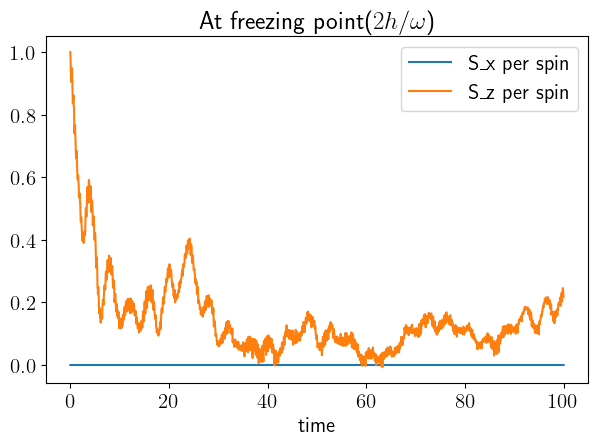

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from qutip import tensor, qeye, destroy, basis, sigmax, sesolve
from scipy.special import jn_zeros

plt.rcParams.update({"figure.figsize": (7, 4.5), "text.usetex": True, "font.size": 15})

# -------------------------------
# parameters
N = 6           # number of spins
n_ph = 25       # photon cutoff
hbar = 1.0

beta = float('inf')
Jvalue = 1
omega = 20
g0 = jn_zeros(0, 1)[0] * omega / 2

# time
ttop = 100

# photon operators
a = destroy(n_ph)
adag = a.dag()
I_ph = qeye(n_ph)

H0 = h0_ham(N, beta, Jvalue)
H0 = tensor(H0, qeye(n_ph)) + hbar * omega * tensor(qeye(2**N), adag*a)

# spin identity (N qubits)
I_spin_full = tensor(*[qeye(2) for _ in range(N)])

# collective Sx
Sx_spin = 0.5 * sum(spin_only_op(sigmax(), i, N) for i in range(N))

# full operator (a+a†) ⊗ Sx
V = tensor(a + adag, Sx_spin)

H0 = Qobj(H0.full())
V = Qobj(V.full())

H = H0 + V
# time-dependence
'''
    Try to get an idea if there is true-freezing at some of the drive paramter

    J_0(2 g_0 /w) = 0
    
'''
# Hamiltonian list for sesolve
#H_td = [[H, coeff]]
H_td = [H0, [V, g_t]]

# -------------------------
# initial state: photon vacuum ⊗ all spins up
spin_up = tensor(*([basis(2, 0)] * N))
psi0 = tensor(basis(n_ph, 1), spin_up)

# observables: photon number, Sx
op_nph = tensor(adag*a, I_spin_full)
op_Sx  = tensor(I_ph, Sx_spin)
op_Sz = tensor(I_ph, sum(spin_only_op(sigmaz(), i, N) for i in range(N)))

# evolve
tlist = np.linspace(0, ttop,  ttop * 20 + 1)
opts = Options(nsteps=1e5)
args = {'omega': 10.0, 'g0': g0, 'opts':opts}
result = sesolve(H_td, psi0, tlist, e_ops=[op_nph, op_Sx, op_Sz], args=args)

# extract results
nph_t = np.real(result.expect[0]) / N
Sx_t  = np.real(result.expect[1]) / N
Sz_t  = np.real(result.expect[2]) / N

# plot
#plt.plot(tlist, nph_t, label='n_ph per spin')
plt.plot(tlist, Sx_t, label='S_x per spin')
plt.plot(tlist, Sz_t, label='S_z per spin')
plt.xlabel("time")
plt.legend()

plt.title(r"At freezing point($2h/\omega$)")
#plt.axhline(y =1, ls = '--', color = 'green')
plt.show()

## Plot -:  $\hat{\mathcal{O}}$ vs $2h/\omega$ 

##### (Multiprocessor code)

In [3]:
from qutip import *
import numpy as np
from itertools import combinations
from scipy.special import jn_zeros

# helper: operator at one site
def spin_only_op(op, site, N):
    ops = [qeye(2) for _ in range(N)]
    ops[site] = op
    return tensor(*ops)

def g_t(t, args):
    g0 = args['g0']
    w = args['omega']
    return g0 * np.cos(w * t)

def gdot_t(t, args):
    g0 = args['g0']
    w = args['omega']
    return g0 * w * np.cos(w * t)

def coeff(t, args):
    return (g_t(t, args) - gdot_t(t, args)) / np.sqrt(N)


def j_ij(Jvalue, i,j, beta):
    return Jvalue/(np.abs(i-j))**beta

def h0_ham(N, beta, Jvalue):
    sx,sy,sz = sigmax(), sigmay(), sigmaz()
    empt = qzero(2**N) + 1j * qzero(2**N)    
    H0, H1, H2 =  empt, empt, empt
    
    comb = combinations(np.arange(N), 2)
    for nm in list(comb):
        i,j= np.array(nm)
        id = qeye(2**i)
        dim11 = j-i-1
        id1 = qeye(2**dim11)
        dim12 = N-1-j
        id2 = qeye(2**dim12)
        H0 = H0 + Qobj(tensor(id, tensor(sx, tensor(id1, tensor(sx,id2)))).full()) * j_ij(Jvalue, i,j, beta)
        
    for i in range(N):
        id = qeye(2 ** i)    
        dim11 = N-1-i
        id1 = qeye(2 ** dim11)
        H1 = H1 + Qobj(tensor(id,tensor(sx,id1)).full())
        
    for i in range(N):
        id = qeye(2 ** i)    
        dim11 = N-1-i
        id1 = qeye(2 ** dim11)
        H2 = H2 + Qobj(tensor(id,tensor(sz,id1)).full())

    return H0 * 2/N, H1, H2

def run_dynamics(args):
    psi0 = args['psi0']
    tlist = args['tlist']
    N = args['N']
    beta = args['beta']
    Jvalue = args['Jvalue']
    
    H0, H1, H2 = h0_ham(N, beta, Jvalue)
    
    H0 = Qobj(H0.full())
    H1 = Qobj(H1.full())
    H2 = Qobj(H2.full())
    psi0 = Qobj(psi0.full())

    H_td = [H0, [H2, g_t]]

    result = mesolve(H_td, psi0, tlist, e_ops=[H1/N, H2/N], args=args)
    op_Sx_avg = np.average(result.expect[0])
    op_Sz_avg = np.average(result.expect[1])
    return op_Sx_avg, op_Sz_avg
    #return result

print("Function defined !")

Function defined !


Without Photon coupling

100%|██████████| 51/51 [00:00<00:00, 32768.00it/s]


Dynamics done ! 

Now plotting...


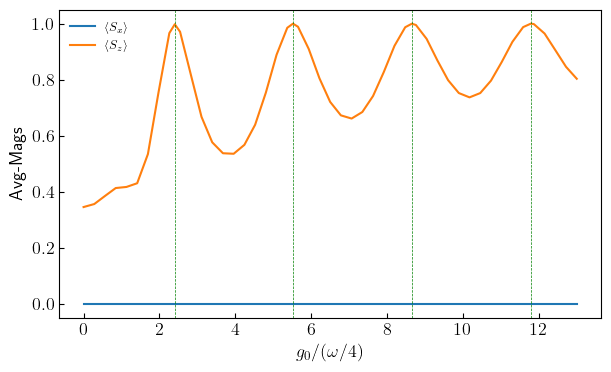

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from qutip import tensor, qeye, destroy, basis, sigmax, sesolve
from scipy.special import jn_zeros
from tqdm import tqdm
from multiprocessing import Pool


plt.rcParams.update({"figure.figsize": (7, 4), "text.usetex": True, "font.size": 13})

# -------------------------------
# Freezing points
frz = jn_zeros(0, 4)

# parameters
N = 5      # number of spins
n_ph = 25       # photon cutoff
hbar = 1.0

beta = float('inf')
Jvalue = 1
omega = 20
g0s = np.linspace(0, 13, 47) *  omega / 4
g0s = np.sort(np.append(g0s, frz * omega / 4))

# time
ttop = 10

nprocs = 5
p = Pool(processes = nprocs) 
opts = Options(nsteps=1e5, num_cpus=1, openmp_threads=1)

# initial state: photon vacuum ⊗ all spins up
spin_up = tensor(*([basis(2, 0)] * N))
psi0 = spin_up

# evolve
tlist = np.linspace(0, ttop,  ttop * 20 + 1)

args = [{'omega': omega, 'g0': g0, 'opts':opts, 'tlist': tlist,\
    'psi0': psi0, 'beta':beta, 'Jvalue': Jvalue, 'N': N} for g0 in g0s]

results = p.map(run_dynamics, tqdm(args))

print("Dynamics done ! \n\nNow plotting...")

results = np.array(results)
Sx_avgs = results[:, 0]
Sz_avgs = results[:, 1]


plt.plot(4 * g0s/omega, Sx_avgs, label=r'$\langle S_x \rangle$')
plt.plot(4 * g0s/omega, Sz_avgs, label=r'$\langle S_z \rangle$')
plt.xlabel(r'$g_0 / ( \omega / 4)$')
plt.ylabel('Avg-Mags')

for i in frz:
    plt.axvline(x = i, ls = '--', color = 'green', lw = 0.5)



plt.tick_params(which='both', direction='in')
plt.legend(frameon=False, fontsize = 9, loc = 'best')
plt.show()



Now change the ising interaction to sxsx

In [7]:
from qutip import *
import numpy as np
from itertools import combinations
from scipy.special import jn_zeros

# helper: operator at one site
def spin_only_op(op, site, N):
    ops = [qeye(2) for _ in range(N)]
    ops[site] = op
    return tensor(*ops)

def g_t(t, args):
    g0 = args['g0']
    w = args['omega']
    return g0 * np.cos(w * t)

def gdot_t(t, args):
    g0 = args['g0']
    w = args['omega']
    return g0 * w * np.cos(w * t)

def coeff(t, args):
    return (g_t(t, args) - gdot_t(t, args)) / np.sqrt(N)


def j_ij(Jvalue, i,j, beta):
    return Jvalue/(np.abs(i-j))**beta

def h0_ham(N, beta, Jvalue):
    sx,sy,sz = sigmax(), sigmay(), sigmaz()
    empt = qzero(2**N) + 1j * qzero(2**N)    
    H0, H1, H2 =  empt, empt, empt
    
    comb = combinations(np.arange(N), 2)
    for nm in list(comb):
        i,j= np.array(nm)
        id = qeye(2**i)
        dim11 = j-i-1
        id1 = qeye(2**dim11)
        dim12 = N-1-j
        id2 = qeye(2**dim12)
        H0 = H0 + Qobj(tensor(id, tensor(sz, tensor(id1, tensor(sz,id2)))).full()) * j_ij(Jvalue, i,j, beta)
        
    for i in range(N):
        id = qeye(2 ** i)    
        dim11 = N-1-i
        id1 = qeye(2 ** dim11)
        H1 = H1 + Qobj(tensor(id,tensor(sx,id1)).full())
        
    for i in range(N):
        id = qeye(2 ** i)    
        dim11 = N-1-i
        id1 = qeye(2 ** dim11)
        H2 = H2 + Qobj(tensor(id,tensor(sz,id1)).full())

    return H0 * 2/N, H1, H2

def run_dynamics(args):
    psi0 = args['psi0']
    tlist = args['tlist']
    N = args['N']
    beta = args['beta']
    Jvalue = args['Jvalue']
    
    H0, H1, H2 = h0_ham(N, beta, Jvalue)
    
    H0 = Qobj(H0.full())
    H1 = Qobj(H1.full())
    H2 = Qobj(H2.full())
    psi0 = Qobj(psi0.full())

    H_td = [H0, [H1, g_t]]

    result = mesolve(H_td, psi0, tlist, e_ops=[H1/N, H2/N], args=args)
    op_Sx_avg = np.average(result.expect[0])
    op_Sz_avg = np.average(result.expect[1])
    return op_Sx_avg, op_Sz_avg
    #return result

print("Function defined !")


Function defined !


100%|██████████| 70/70 [00:00<00:00, 157.64it/s]


Dynamics done ! 

Now plotting...


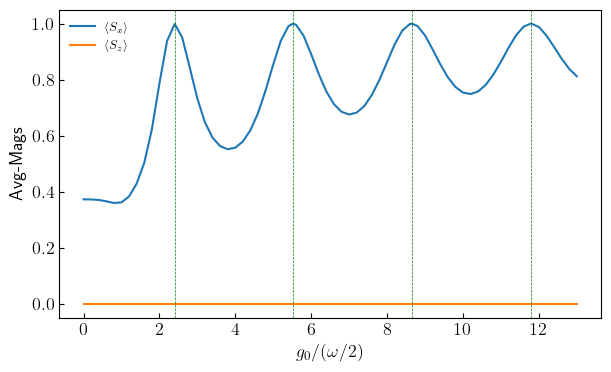

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from qutip import tensor, qeye, destroy, basis, sigmax, sesolve
from scipy.special import jn_zeros
from tqdm import tqdm
from multiprocessing import Pool


plt.rcParams.update({"figure.figsize": (7, 4), "text.usetex": True, "font.size": 13})

# -------------------------------
# Freezing points
frz = jn_zeros(0, 4)

# parameters
N = 6      # number of spins
n_ph = 25       # photon cutoff
hbar = 1.0

beta = float('inf')
Jvalue = 1
omega = 20
g0s = np.linspace(0, 13, 66) *  omega / 4
g0s = np.sort(np.append(g0s, frz * omega / 4))

# time
ttop = 10

nprocs = 10
p = Pool(processes = nprocs) 
opts = Options(nsteps=1e5, num_cpus=1, openmp_threads=1)

# initial state: photon vacuum ⊗ all spins up
H0, H1, H2 = h0_ham(N, beta, Jvalue)
en, st = H1.eigenstates()
psi0 = st[-1]/ (np.sqrt(2)**N)

# evolve
tlist = np.linspace(0, ttop,  ttop * 20 + 1)

args = [{'omega': omega, 'g0': g0, 'opts':opts, 'tlist': tlist,\
    'psi0': psi0, 'beta':beta, 'Jvalue': Jvalue, 'N': N} for g0 in g0s]

results = p.map(run_dynamics, tqdm(args))

print("Dynamics done ! \n\nNow plotting...")

results = np.array(results)
Sx_avgs = results[:, 0]
Sz_avgs = results[:, 1]


plt.plot(4 * g0s/omega, Sx_avgs, label=r'$\langle S_x \rangle$')
plt.plot(4 * g0s/omega, Sz_avgs, label=r'$\langle S_z \rangle$')
plt.xlabel(r'$g_0 / ( \omega / 2)$')
plt.ylabel('Avg-Mags')

for i in frz:
    plt.axvline(x = i, ls = '--', color = 'green', lw = 0.5)

plt.tick_params(which='both', direction='in')
plt.legend(frameon=False, fontsize = 9, loc = 'best')
plt.show()


Now we introduce photon coupling

In [ ]:
from qutip import *
import numpy as np
from itertools import combinations
from scipy.special import jn_zeros

# helper: operator at one site
def spin_only_op(op, site, N):
    ops = [qeye(2) for _ in range(N)]
    ops[site] = op
    return tensor(*ops)

def g_t(t, args):
    g0 = args['g0']
    w = args['omega']
    return g0 * np.cos(w * t)

def gdot_t(t, args):
    g0 = args['g0']
    w = args['omega']
    return g0 * w * np.cos(w * t)

def coeff(t, args):
    return (g_t(t, args) - gdot_t(t, args)) / np.sqrt(N)


def j_ij(Jvalue, i,j, beta):
    return Jvalue/(np.abs(i-j))**beta

def h0_ham(N, beta, Jvalue, n_ph, hbar, omega, omega0, omegaC):
    sx,sy,sz = sigmax(), sigmay(), sigmaz()
    empt = qzero(2**N) + 1j * qzero(2**N)
    H0, H1, H2 = empt, empt, empt

    comb = combinations(np.arange(N), 2)
    for nm in list(comb):
        i,j= np.array(nm)
        id = qeye(2**i)
        dim11 = j-i-1
        id1 = qeye(2**dim11)
        dim12 = N-1-j
        id2 = qeye(2**dim12)
        H0 = H0 + Qobj(tensor(id, tensor(sz, tensor(id1, tensor(sz,id2)))).full()) * j_ij(Jvalue, i,j, beta)
        
    for i in range(N):
        id = qeye(2 ** i)    
        dim11 = N-1-i
        id1 = qeye(2 ** dim11)
        H1 = H1 + Qobj(tensor(id,tensor(sx,id1)).full())
        
    for i in range(N):
        id = qeye(2 ** i)    
        dim11 = N-1-i
        id1 = qeye(2 ** dim11)
        H2 = H2 + Qobj(tensor(id,tensor(sz,id1)).full())
        
    # photon operators
    a = destroy(n_ph)
    adag = a.dag()
    I_ph = qeye(n_ph)
    
    H0 = Qobj(tensor(H0, qeye(n_ph)).full())
    H1 = Qobj(tensor(H1, a + adag).full())/np.sqrt(N)
    H2 = Qobj(tensor(omega0 * H2, I_ph).full())
    H3 = hbar * omegaC * Qobj(tensor(adag*a, qeye(2**N)).full())

    return H0 * 1/N, H1, H2, H3

def run_dynamics(args):
    tlist = args['tlist']
    N = args['N']
    beta = args['beta']
    Jvalue = args['Jvalue']
    n_ph = args['n_ph']
    hbar = args['hbar']
    omega = args['omega']
    omegaC = args['omegaC']
    omega0 = args['omega0']

    H0, H1, H2, H3 = h0_ham(N, beta, Jvalue, n_ph, hbar, omega, omega0, omegaC)

    H0 = Qobj(H0.full())
    H1 = Qobj(H1.full())
    H2 = Qobj(H2.full())
    H3 = Qobj(H3.full())
    
    en, st = H1.eigenstates()
    psi0 = st[-1]
    
    
    H_td = [H0, [H1, g_t], H3]
    #H_td = [H0, [H1, g_t]]

    result = mesolve(H_td, psi0, tlist, e_ops=[H1/N, H2/N], args=args)
    op_Sx_avg = np.average(result.expect[0])
    op_Sz_avg = np.average(result.expect[1])
    return op_Sx_avg, op_Sz_avg
    #return result

print("Function defined !")



Function defined !


100%|██████████| 50/50 [00:00<00:00, 21859.00it/s]


Dynamics done ! 

Now plotting...


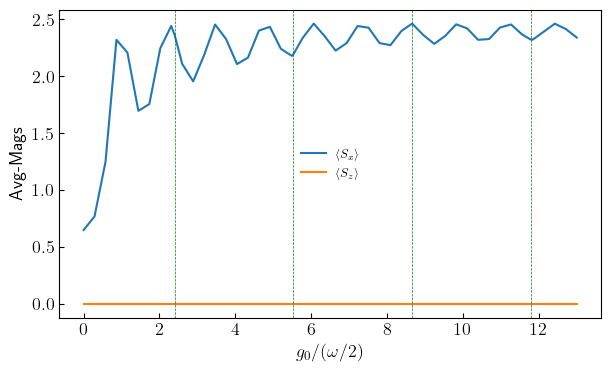

CPU times: user 120 ms, sys: 132 ms, total: 251 ms
Wall time: 48.1 s


In [36]:
%%time

import numpy as np
import matplotlib.pyplot as plt
from qutip import tensor, qeye, destroy, basis, sigmax, sesolve
from scipy.special import jn_zeros
from tqdm import tqdm
from multiprocessing import Pool


plt.rcParams.update({"figure.figsize": (7, 4), "text.usetex": True, "font.size": 13})

# -------------------------------
# Freezing points
frz = jn_zeros(0, 4)

# parameters
N = 5     # number of spins
n_ph = 12       # photon cutoff
hbar = 1.0
omegaC = .5
omega0 = 0

beta = float('inf')
Jvalue = 1
omega = 20
g0s = np.linspace(0, 13, 46) *  omega / 4
g0s = np.sort(np.append(g0s, frz * omega / 4))

# time
ttop = 10

nprocs = 10
p = Pool(processes = nprocs) 
opts = Options(nsteps=1e5, num_cpus=1, openmp_threads=1)

# evolve
tlist = np.linspace(0, ttop,  ttop * 20 + 1)

args = [{'omega': omega, 'g0': g0, 'opts':opts, 'tlist': tlist,\
    'beta':beta, 'Jvalue': Jvalue, 'N': N,\
        'n_ph': n_ph, 'hbar': hbar, 'omegaC': omegaC, 'omega0': omega0} for g0 in g0s]

results = p.map(run_dynamics, tqdm(args))

print("Dynamics done ! \n\nNow plotting...")

results = np.array(results)
Sx_avgs = results[:, 0]
Sz_avgs = results[:, 1]


plt.plot(4 * g0s/omega , Sx_avgs, label=r'$\langle S_x \rangle$')
plt.plot(4 * g0s/omega , Sz_avgs, label=r'$\langle S_z \rangle$')
plt.xlabel(r'$g_0 / ( \omega / 2)$')
plt.ylabel('Avg-Mags')

for i in frz:
    plt.axvline(x = i, ls = '--', color = 'green', lw = 0.5)

plt.tick_params(which='both', direction='in')
plt.legend(frameon=False, fontsize = 9, loc = 'best')
plt.show()



In [25]:
# photon operators
a = destroy(n_ph)
adag = a.dag()
I_ph = qeye(n_ph)

adag * a

Quantum object: dims = [[10], [10]], shape = (10, 10), type = oper, isherm = True
Qobj data =
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 2. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 3. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 4. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 5. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 6. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 7. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 8. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 9.]]

In [12]:
from qutip import *
import numpy as np
from itertools import combinations
from scipy.special import jn_zeros

# helper: operator at one site
def spin_only_op(op, site, N):
    ops = [qeye(2) for _ in range(N)]
    ops[site] = op
    return tensor(*ops)

def g_t(t, args):
    g0 = args['g0']
    w = args['omega']
    return g0 * np.cos(w * t)

def gdot_t(t, args):
    g0 = args['g0']
    w = args['omega']
    return g0 * w * np.cos(w * t)

def coeff(t, args):
    return (g_t(t, args) - gdot_t(t, args)) / np.sqrt(N)


def j_ij(Jvalue, i,j, beta):
    return Jvalue/(np.abs(i-j))**beta

def h0_ham(N, beta, Jvalue, n_ph, hbar, omega, omega0, omegaC):
    sx,sy,sz = sigmax(), sigmay(), sigmaz()
    empt = qzero(2**N) + 1j * qzero(2**N)
    H0, H1, H2 = empt, empt, empt

    comb = combinations(np.arange(N), 2)
    for nm in list(comb):
        i,j= np.array(nm)
        id = qeye(2**i)
        dim11 = j-i-1
        id1 = qeye(2**dim11)
        dim12 = N-1-j
        id2 = qeye(2**dim12)
        H0 = H0 + Qobj(tensor(id, tensor(sz, tensor(id1, tensor(sz,id2)))).full()) * j_ij(Jvalue, i,j, beta)
        
    for i in range(N):
        id = qeye(2 ** i)    
        dim11 = N-1-i
        id1 = qeye(2 ** dim11)
        H1 = H1 + Qobj(tensor(id,tensor(sx,id1)).full())
        
    for i in range(N):
        id = qeye(2 ** i)    
        dim11 = N-1-i
        id1 = qeye(2 ** dim11)
        H2 = H2 + Qobj(tensor(id,tensor(sz,id1)).full())
        
    # photon operators
    a = destroy(n_ph)
    adag = a.dag()
    I_ph = qeye(n_ph)
    
    H0 = Qobj(tensor(H0, qeye(n_ph)).full())
    H1 = Qobj(tensor(H1, a + adag).full())/np.sqrt(N)
    H2 = Qobj(tensor(omega0 * H2, I_ph).full())
    H3 = hbar * omegaC * Qobj(tensor(adag*a, qeye(2**N)).full())

    return H0 * 1/N, H1, H2, H3

def run_dynamics(args):
    tlist = args['tlist']
    N = args['N']
    beta = args['beta']
    Jvalue = args['Jvalue']
    n_ph = args['n_ph']
    hbar = args['hbar']
    omega = args['omega']
    omegaC = args['omegaC']
    omega0 = args['omega0']

    H0, H1, H2, H3 = h0_ham(N, beta, Jvalue, n_ph, hbar, omega, omega0, omegaC)

    H0 = Qobj(H0.full())
    H1 = Qobj(H1.full())
    H2 = Qobj(H2.full())
    H3 = Qobj(H3.full())
    
    en, st = H1.eigenstates()
    psi0 = st[-1]
    
    H_td = [H0, [H1, g_t], H3]
    #H_td = [H0, [H1, g_t]]

    result = mesolve(H_td, psi0, tlist, e_ops=[H1/(N+n_ph/2), H2/N], args=args)
    op_Sx_avg = np.average(result.expect[0])
    op_Sz_avg = np.average(result.expect[1])
    return op_Sx_avg, op_Sz_avg
    #return result

print("Function defined !")



Function defined !


100%|██████████| 100/100 [00:24<00:00,  4.14it/s]


Dynamics done ! 

Now plotting...


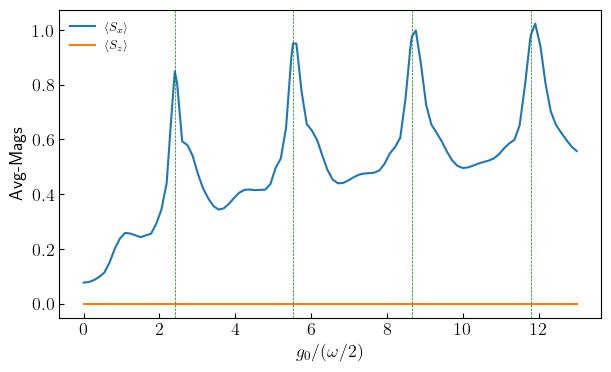

CPU times: user 146 ms, sys: 90.4 ms, total: 236 ms
Wall time: 1min 26s


In [13]:
%%time
import numpy as np
import matplotlib.pyplot as plt
from qutip import tensor, qeye, destroy, basis, sigmax, sesolve
from scipy.special import jn_zeros
from tqdm import tqdm
from multiprocessing import Pool

plt.rcParams.update({"figure.figsize": (7, 4), "text.usetex": True, "font.size": 13})

# -------------------------------
# Freezing points
frz = jn_zeros(0, 4)

# parameters
N = 6     # number of spins
n_ph = 10       # photon cutoff
hbar = 1.0
omegaC = 1
omega0 = 0

beta = float('inf')
Jvalue = 1
omega = 20
g0s = np.linspace(0, 13, 96) *  omega / 4
g0s = np.sort(np.append(g0s, frz * omega / 4))

# time
ttop = 10

nprocs = 20
p = Pool(processes = nprocs) 
opts = Options(nsteps=1e5, num_cpus=1, openmp_threads=1)

# evolve
tlist = np.linspace(0, ttop,  ttop * 20 + 1)

args = [{'omega': omega, 'g0': g0, 'opts':opts, 'tlist': tlist,\
    'beta':beta, 'Jvalue': Jvalue, 'N': N,\
        'n_ph': n_ph, 'hbar': hbar, 'omegaC': omegaC, 'omega0': omega0} for g0 in g0s]

results = p.map(run_dynamics, tqdm(args))

print("Dynamics done ! \n\nNow plotting...")
results = np.array(results)
Sx_avgs = results[:, 0]
Sz_avgs = results[:, 1]

plt.plot(4 * g0s/omega , Sx_avgs, label=r'$\langle S_x \rangle$')
plt.plot(4 * g0s/omega , Sz_avgs, label=r'$\langle S_z \rangle$')
plt.xlabel(r'$g_0 / ( \omega / 2)$')
plt.ylabel('Avg-Mags')

for i in frz:
    plt.axvline(x = i, ls = '--', color = 'green', lw = 0.5)

plt.tick_params(which='both', direction='in')
plt.legend(frameon=False, fontsize = 9, loc = 'best')
plt.show()



Quasi-energy spectrum

In [80]:
from qutip import *
import numpy as np
from itertools import combinations
from scipy.special import jn_zeros

# helper: operator at one site
def spin_only_op(op, site, N):
    ops = [qeye(2) for _ in range(N)]
    ops[site] = op
    return tensor(*ops)

def g_t(t, args):
    g0 = args['g0']
    w = args['omega']
    return g0 * np.cos(w * t)

def gdot_t(t, args):
    g0 = args['g0']
    w = args['omega']
    return g0 * w * np.cos(w * t)

def coeff(t, args):
    return (g_t(t, args) - gdot_t(t, args)) / np.sqrt(N)


def j_ij(Jvalue, i,j, beta):
    return Jvalue/(np.abs(i-j))**beta

def h0_ham(N, beta, Jvalue, n_ph, hbar, omega, omega0, omegaC):
    sx,sy,sz = sigmax(), sigmay(), sigmaz()
    empt = qzero(2**N) + 1j * qzero(2**N)
    H0, H1, H2 = empt, empt, empt

    comb = combinations(np.arange(N), 2)
    for nm in list(comb):
        i,j= np.array(nm)
        id = qeye(2**i)
        dim11 = j-i-1
        id1 = qeye(2**dim11)
        dim12 = N-1-j
        id2 = qeye(2**dim12)
        H0 = H0 + Qobj(tensor(id, tensor(sz, tensor(id1, tensor(sz,id2)))).full()) * j_ij(Jvalue, i,j, beta)
        
    for i in range(N):
        id = qeye(2 ** i)    
        dim11 = N-1-i
        id1 = qeye(2 ** dim11)
        H1 = H1 + Qobj(tensor(id,tensor(sx,id1)).full())
        
    for i in range(N):
        id = qeye(2 ** i)    
        dim11 = N-1-i
        id1 = qeye(2 ** dim11)
        H2 = H2 + Qobj(tensor(id,tensor(sz,id1)).full())
        
    # photon operators
    a = destroy(n_ph)
    adag = a.dag()
    I_ph = qeye(n_ph)
    
    H0 = Qobj(tensor(H0, qeye(n_ph)).full())
    H1 = Qobj(tensor(H1, a + adag).full())/np.sqrt(N)
    H2 = Qobj(tensor(omega0 * H2, I_ph).full())
    H3 = hbar * omegaC * Qobj(tensor(adag*a, qeye(2**N)).full())

    return H0 * 1/N, H1, H2, H3

def run_dynamics(args):
    tlist = args['tlist']
    N = args['N']
    beta = args['beta']
    Jvalue = args['Jvalue']
    n_ph = args['n_ph']
    hbar = args['hbar']
    omega = args['omega']
    omegaC = args['omegaC']
    omega0 = args['omega0']

    H0, H1, H2, H3 = h0_ham(N, beta, Jvalue, n_ph, hbar, omega, omega0, omegaC)

    H0 = Qobj(H0.full())
    H1 = Qobj(H1.full())
    H2 = Qobj(H2.full())
    H3 = Qobj(H3.full())
    
    en, st = H1.eigenstates()
    psi0 = st[-1]
    
    H_td = [H0, [H1, g_t], H3]
    #H_td = [H0, [H1, g_t]]

    result = mesolve(H_td, psi0, tlist, e_ops=[H1/(N+n_ph/2), H2/N], args=args)
    op_Sx_avg = np.average(result.expect[0])
    op_Sz_avg = np.average(result.expect[1])
    return op_Sx_avg, op_Sz_avg
    #return result

def floquet_dynm(args):
    tlist = args['tlist']
    N = args['N']
    beta = args['beta']
    Jvalue = args['Jvalue']
    n_ph = args['n_ph']
    hbar = args['hbar']
    omega = args['omega']
    omegaC = args['omegaC']
    omega0 = args['omega0']

    H0, H1, H2, H3 = h0_ham(N, beta, Jvalue, n_ph, hbar, omega, omega0, omegaC)

    H0 = Qobj(H0.full())
    H1 = Qobj(H1.full())
    H2 = Qobj(H2.full())
    H3 = Qobj(H3.full())
    
    en, st = H1.eigenstates()
    psi0 = st[-1]
    
    H_td = [H0, [H1, g_t], H3]
    #H_td = [H0, [H1, g_t]]

    # Floquet quasienergies and states
    f_modes_0, f_energies = floquet_modes(H_td, T=2 * np.pi / omega, args=args)
    
    return f_energies

print("Function defined !")



Function defined !


In [142]:
%%time
import numpy as np
import matplotlib.pyplot as plt
from qutip import tensor, qeye, destroy, basis, sigmax, sesolve, Options, Qobj
from scipy.special import jn_zeros
from tqdm import tqdm
from multiprocessing import Pool

def spin_only_op(op, site, N):
    ops = [qeye(2) for _ in range(N)]
    ops[site] = op
    return tensor(*ops)

def g_t(t, args):
    g0 = args['g0']
    w = args['omega']
    return g0 * np.cos(w * t)

def gdot_t(t, args):
    g0 = args['g0']
    w = args['omega']
    return g0 * w * np.cos(w * t)

def j_ij(Jvalue, i, j, beta):
    return Jvalue / (np.abs(i - j)) ** beta

def h0_ham(N, beta, Jvalue, n_ph, hbar, omega, omega0, omegaC):
    from itertools import combinations
    sx, sy, sz = sigmax(), sigmay(), sigmaz()
    empt = Qobj(np.zeros((2**N, 2**N))) + 1j * Qobj(np.zeros((2**N, 2**N)))
    H0, H1, H2 = empt, empt, empt

    comb = combinations(np.arange(N), 2)
    for nm in list(comb):
        i, j = np.array(nm)
        id = qeye(2**i)
        dim11 = j - i - 1
        id1 = qeye(2**dim11)
        dim12 = N - 1 - j
        id2 = qeye(2**dim12)
        H0 = H0 + Qobj(tensor(id, tensor(sz, tensor(id1, tensor(sz, id2)))).full()) * j_ij(Jvalue, i, j, beta)

    for i in range(N):
        id = qeye(2 ** i)
        dim11 = N - 1 - i
        id1 = qeye(2 ** dim11)
        H1 = H1 + Qobj(tensor(id, tensor(sx, id1)).full())

    for i in range(N):
        id = qeye(2 ** i)
        dim11 = N - 1 - i
        id1 = qeye(2 ** dim11)
        H2 = H2 + Qobj(tensor(id, tensor(sz, id1)).full())

    # photon operators
    a = destroy(n_ph)
    adag = a.dag()
    I_ph = qeye(n_ph)

    H0 = Qobj(tensor(H0, qeye(n_ph)).full())
    H1 = Qobj(tensor(H1, a + adag).full()) / np.sqrt(N)
    H2 = Qobj(tensor(omega0 * H2, I_ph).full())
    H3 = hbar * omegaC * Qobj(tensor(adag * a, qeye(2**N)).full())

    return H0 * 1 / N, H1, H2, H3

def floquet_dynm(args):
    from qutip import floquet_modes
    tlist = args['tlist']
    N = args['N']
    beta = args['beta']
    Jvalue = args['Jvalue']
    n_ph = args['n_ph']
    hbar = args['hbar']
    omega = args['omega']
    omegaC = args['omegaC']
    omega0 = args['omega0']

    H0, H1, H2, H3 = h0_ham(N, beta, Jvalue, n_ph, hbar, omega, omega0, omegaC)

    H0 = Qobj(H0.full())
    H1 = Qobj(H1.full())
    H2 = Qobj(H2.full())
    H3 = Qobj(H3.full())

    en, st = H1.eigenstates()
    psi0 = st[-1]

    H_td = [H0, [H1, g_t], H3]

    # Floquet quasienergies and states
    f_modes_0, f_energies = floquet_modes(H_td, T=2 * np.pi / omega, args=args)

    return f_energies

plt.rcParams.update({"figure.figsize": (7, 4), "text.usetex": True, "font.size": 13})
# -------------------------------
# Freezing points
frz = jn_zeros(0, 4)

# parameters
N = 6           # number of spins
n_ph = 10       # photon cutoff
hbar = 1.0
omegaC = 1
omega0 = 0

beta = float('inf')
Jvalue = 1
omega = 20

g0s = [1 * omega / 4, frz[3] * omega / 4]

# time
ttop = 10

nprocs = 2
p = Pool(processes=nprocs)
opts = Options(nsteps=1e5, num_cpus=1, openmp_threads=1)

# evolve
tlist = np.linspace(0, ttop, ttop * 20 + 1)

args = [{'omega': omega, 'g0': g0, 'opts': opts, 'tlist': tlist,
         'beta': beta, 'Jvalue': Jvalue, 'N': N,
         'n_ph': n_ph, 'hbar': hbar, 'omegaC': omegaC, 'omega0': omega0} for g0 in g0s]

q_e = p.map(floquet_dynm, tqdm(args))


100%|██████████| 2/2 [00:00<00:00, 2362.32it/s]


CPU times: user 7.24 ms, sys: 37.1 ms, total: 44.3 ms
Wall time: 48.7 s


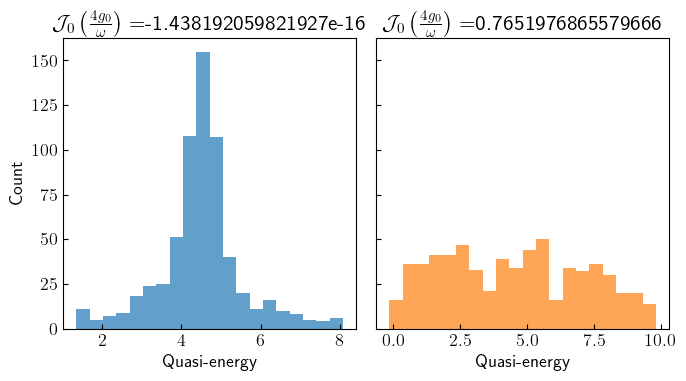

In [143]:
import matplotlib.pyplot as plt
from scipy.special import jv as scipy_jv

plt.rcParams.update({"figure.figsize": (7, 4), "text.usetex": True, "font.size": 13})

# Use the first two sets of quasienergies from q_e
energies_0 = q_e[1]
energies_1 = q_e[0]

# Remove negative values
energies_0_pos = energies_0
energies_1_pos = energies_1

fig, axes = plt.subplots(1, 2, sharey=True)

axes[0].hist(energies_0_pos, bins=20, color='C0', alpha=0.7, histtype='stepfilled')
axes[0].set_title(r'$\mathcal{J}_0\left(\frac{4 g_0}{\omega}\right)=$' + str(scipy_jv(0, 4 * g0s[1]/omega)))
axes[0].set_xlabel('Quasi-energy')
axes[0].set_ylabel('Count')
axes[0].set_ylim(bottom=0)

axes[1].hist(energies_1_pos, bins=20, color='C1', alpha=0.7, histtype='stepfilled')
axes[1].set_title(r'$\mathcal{J}_0\left(\frac{4 g_0}{\omega}\right)=$' + str(scipy_jv(0, 4 * g0s[0]/omega)))
axes[1].set_xlabel('Quasi-energy')
axes[1].set_ylim(bottom=0)

axes[0].tick_params(which='both', direction='in')
axes[1].tick_params(which='both', direction='in')
plt.tight_layout()
plt.show()


In [144]:
from scipy.stats import norm, poisson

# Choose your data, for example, use energies_0_pos
data = energies_1_pos

# Fit Gaussian (Normal) distribution
mu, std = norm.fit(data)

# Fit Poisson distribution (Poisson is for integer data, so we round)
data_int = np.round(data[data < 20])  # restrict to reasonable range for Poisson
data_int = data_int[data_int >= 0]
lambda_poisson = np.mean(data_int)

# Compare log-likelihoods to decide which fit is better
ll_gauss = np.sum(norm.logpdf(data, mu, std))
ll_pois = np.sum(poisson.logpmf(data_int, lambda_poisson)) if len(data_int) > 0 else float('-inf')

if ll_gauss > ll_pois:
    print(f"Gaussian fit is better: mu={mu:.3f}, std={std:.3f}")
else:
    print(f"Poisson fit is better: lambda={lambda_poisson:.3f}")

Gaussian fit is better: mu=4.500, std=2.634


In [145]:
def level_statistic_ratio(energies):
    """
    Calculate the average level statistic ratio r for a set of energy levels.
    r_n = min(s_n, s_{n-1}) / max(s_n, s_{n-1})
    where s_n = E_{n+1} - E_n
    """
    energies = np.sort(energies)
    spacings = np.diff(energies)
    # Remove zero spacings to avoid division by zero
    valid = (spacings[1:] != 0) & (spacings[:-1] != 0)
    r = np.minimum(spacings[1:], spacings[:-1])[valid] / np.maximum(spacings[1:], spacings[:-1])[valid]
    return np.mean(r) if len(r) > 0 else np.nan

# Calculate level statistic ratio for energies_0_pos and energies_1_pos
r_energies_0_pos = level_statistic_ratio(energies_0_pos)
r_energies_1_pos = level_statistic_ratio(energies_1_pos)

print(f"Level statistic ratio for energies_0_pos: {r_energies_0_pos:.3f}")
print(f"Level statistic ratio for energies_1_pos: {r_energies_1_pos:.3f}")

Level statistic ratio for energies_0_pos: 0.351
Level statistic ratio for energies_1_pos: 0.181


In [112]:
%%time
import numpy as np
import matplotlib.pyplot as plt
from qutip import tensor, qeye, destroy, basis, sigmax, sesolve
from scipy.special import jn_zeros
from tqdm import tqdm
from multiprocessing import Pool

plt.rcParams.update({"figure.figsize": (7, 4), "text.usetex": True, "font.size": 13})
# -------------------------------
# Freezing points
frz = jn_zeros(0, 3)

# parameters
N = 6           # number of spins
n_ph = 10       # photon cutoff
hbar = 1.0
omegaC = 1
omega0 = 0

beta = float('inf')
Jvalue = 1
omega = 20

#g0s = [7 *  omega / 4, frz * omega / 4]

g0s = np.linspace(0, 13, 16) *  omega / 4
g0s = np.sort(np.append(g0s, frz * omega / 4))

# time
ttop = 10

nprocs = 20
p = Pool(processes = nprocs) 
opts = Options(nsteps=1e5, num_cpus=1, openmp_threads=1)

# evolve
tlist = np.linspace(0, ttop,  ttop * 20 + 1)

args = [{'omega': omega, 'g0': g0, 'opts':opts, 'tlist': tlist,\
    'beta':beta, 'Jvalue': Jvalue, 'N': N,\
        'n_ph': n_ph, 'hbar': hbar, 'omegaC': omegaC, 'omega0': omega0} for g0 in g0s]

q_e = p.map(floquet_dynm, tqdm(args))


100%|██████████| 19/19 [00:00<00:00, 14771.41it/s]


CPU times: user 61.8 ms, sys: 280 ms, total: 342 ms
Wall time: 7min 58s


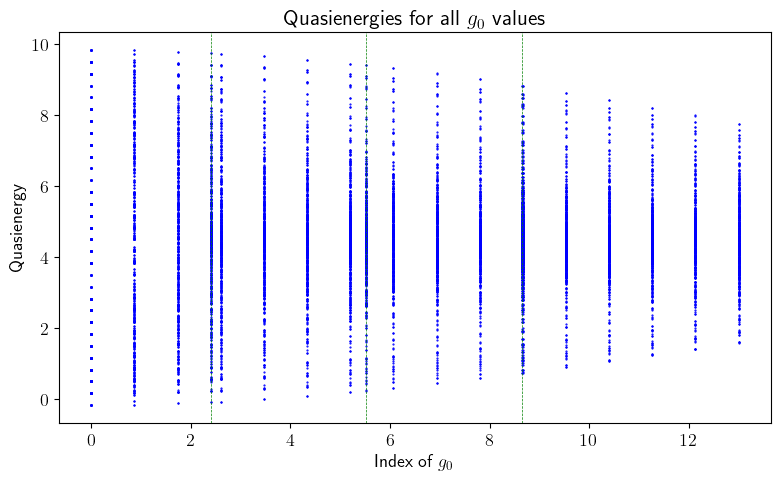

In [117]:
# Plot all sets of quasienergies in q_e as scatter plots

plt.figure(figsize=(8, 5))
for i, energies in enumerate(q_e):
    x_vals = np.ones(len(energies)) * g0s[i]
    plt.scatter(x_vals * 4/omega, energies, marker='o', s=0.3, color = 'blue', label=fr'$g_0 = {i}$' if i < 5 else None)
    
    
# Plot axvline in green at freezing points
for i in frz:
    plt.axvline(x = i, ls = '--', color = 'green', lw = 0.5)  
    

#plt.xticks(range(len(q_e)), [fr'$g_0[{i}]$' for i in range(len(q_e))], rotation=90)
plt.ylabel('Quasienergy')
plt.xlabel('Index of $g_0$')
plt.title('Quasienergies for all $g_0$ values')
plt.tight_layout()
plt.show()

In [109]:
def level_statistic_ratio(energies):
    """
    Calculate the average level statistic ratio r for a set of energy levels.
    r_n = min(s_n, s_{n-1}) / max(s_n, s_{n-1})
    where s_n = E_{n+1} - E_n
    """
    energies = np.sort(energies)
    spacings = np.diff(energies)
    # Remove zero spacings to avoid division by zero
    valid = (spacings[1:] != 0) & (spacings[:-1] != 0)
    r = np.minimum(spacings[1:], spacings[:-1])[valid] / np.maximum(spacings[1:], spacings[:-1])[valid]
    return np.mean(r) if len(r) > 0 else np.nan

# Calculate for all sets in q_e
r_all = [level_statistic_ratio(e) for e in q_e]
for i, r in enumerate(r_all):
    print(f"Level statistic ratio for q_e[{i}]: {r:.3f}")


Level statistic ratio for q_e[0]: nan
Level statistic ratio for q_e[1]: 0.333
Level statistic ratio for q_e[2]: 0.369
Level statistic ratio for q_e[3]: 0.404
Level statistic ratio for q_e[4]: 0.377
Level statistic ratio for q_e[5]: 0.381
Level statistic ratio for q_e[6]: 0.378
Level statistic ratio for q_e[7]: 0.360
Level statistic ratio for q_e[8]: 0.379
Level statistic ratio for q_e[9]: 0.381
Level statistic ratio for q_e[10]: 0.373
Level statistic ratio for q_e[11]: 0.375
Level statistic ratio for q_e[12]: 0.377
Level statistic ratio for q_e[13]: 0.395
Level statistic ratio for q_e[14]: 0.403
Level statistic ratio for q_e[15]: 0.373
Level statistic ratio for q_e[16]: 0.385
Level statistic ratio for q_e[17]: 0.364
Level statistic ratio for q_e[18]: 0.382


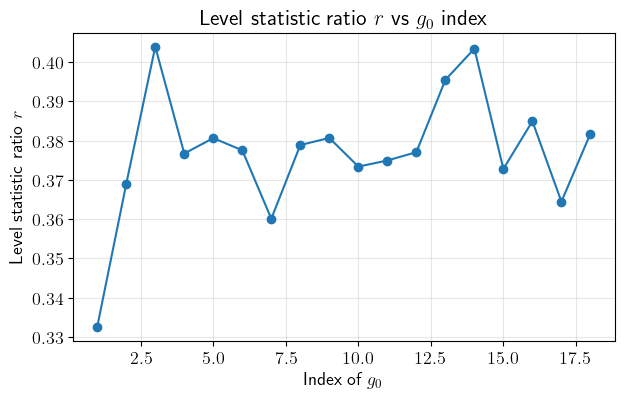

In [111]:
import matplotlib.pyplot as plt

plt.figure(figsize=(7, 4))
plt.plot(range(len(r_all)), r_all, marker='o', linestyle='-', color='C0')
plt.xlabel('Index of $g_0$')
plt.ylabel('Level statistic ratio $r$')
plt.title('Level statistic ratio $r$ vs $g_0$ index')
plt.grid(True, alpha=0.3)
plt.show()

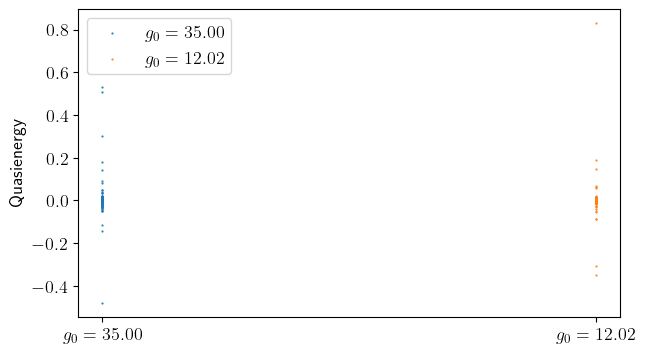

In [95]:
# Plot the two sets of quasienergies as scatter plots

x0 = np.zeros_like(energies_0)
x1 = np.ones_like(energies_1)

plt.scatter(x0, energies_0, marker='o', label=fr'$g_0 = {g0s[0]:.2f}$', s=0.3)
plt.scatter(x1, energies_1, marker='o', label=fr'$g_0 = {g0s[1]:.2f}$', s=0.3)
plt.xticks([0, 1], [fr'$g_0 = {g0s[0]:.2f}$', fr'$g_0 = {g0s[1]:.2f}$'])
plt.ylabel('Quasienergy')
plt.legend()
plt.show()


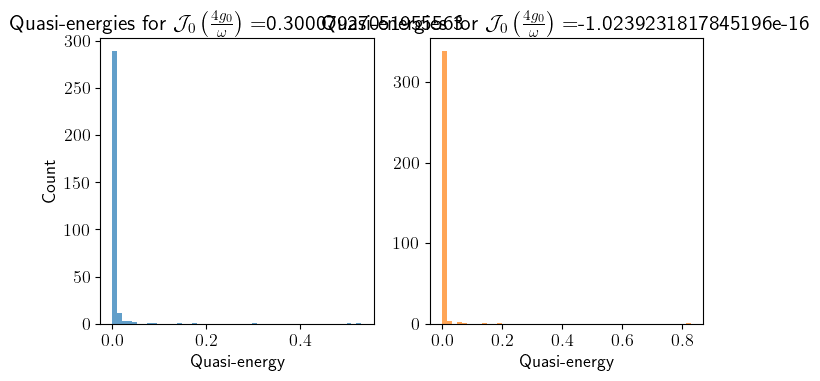

In [97]:
import matplotlib.pyplot as plt

from scipy.special import jv as scipy_jv
plt.rcParams.update({"figure.figsize": (7, 4), "text.usetex": True, "font.size": 13})


# Remove negative values from energies_0 and energies_1
energies_0_pos = energies_0[energies_0 >= 0]
energies_1_pos = energies_1[energies_1 >= 0]

# Draw histograms for both quasi-energy datasets side by side
fig, axes = plt.subplots(1, 2, sharey=False)

# Histogram for the first dataset (energies_0)
axes[0].hist(energies_0_pos, bins=50, color='C0', alpha=0.7, histtype='stepfilled')
axes[0].set_title(r'Quasi-energies for $\mathcal{J}_0\left(\frac{4 g_0}{\omega}\right)=$' + str(scipy_jv(0, 4 * g0s[0]/omega)))
axes[0].set_xlabel('Quasi-energy')
axes[0].set_ylabel('Count')
#axes[0].set_yscale('log')
axes[0].set_ylim(bottom=0)

# Histogram for the second dataset (energies_1)
axes[1].hist(energies_1_pos, bins=50, color='C1', alpha=0.7, histtype='stepfilled')
axes[1].set_title(r'Quasi-energies for $\mathcal{J}_0\left(\frac{4 g_0}{\omega}\right)=$' + str(scipy_jv(0, 4 * g0s[1]/omega)))
axes[1].set_xlabel('Quasi-energy')
#axes[1].set_yscale('log')
axes[1].set_ylim(bottom=0)

plt.tight_layout()
plt.show()

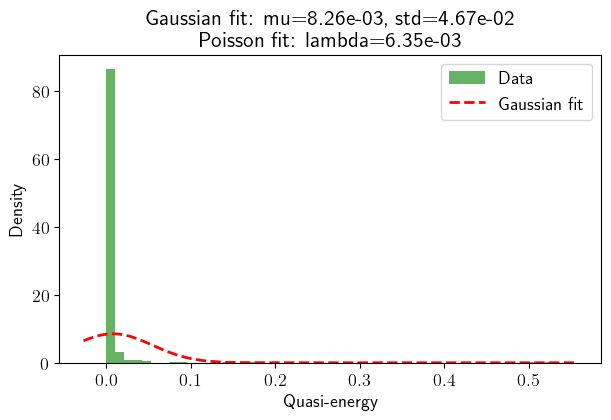

In [100]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, poisson

# Histogram data
data = energies_0_pos

# Fit Gaussian (Normal) distribution
mu, std = norm.fit(data)

# Fit Poisson distribution (Poisson is for integer data, so we round)
data_int = np.round(data[data < 20])  # restrict to reasonable range for Poisson
data_int = data_int[data_int >= 0]
lambda_poisson = np.mean(data_int)

# Plot histogram
plt.hist(data, bins=50, density=True, alpha=0.6, color='g', label='Data')

# Plot Gaussian fit
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 500)
p_gauss = norm.pdf(x, mu, std)
plt.plot(x, p_gauss, 'r--', linewidth=2, label='Gaussian fit')

# Plot Poisson fit (only for integer x)
x_pois = np.arange(int(xmin), int(xmax))
p_pois = poisson.pmf(x_pois, lambda_poisson)
# Only plot Poisson fit if x_pois is not empty
if len(x_pois) > 0 and len(p_pois) > 0:
    plt.stem(x_pois, p_pois, 'b', markerfmt='bo', basefmt=" ", label='Poisson fit', use_line_collection=True)

plt.xlabel('Quasi-energy')
plt.ylabel('Density')
plt.legend()
plt.title(f'Gaussian fit: mu={mu:.2e}, std={std:.2e}\nPoisson fit: lambda={lambda_poisson:.2e}')
plt.show()

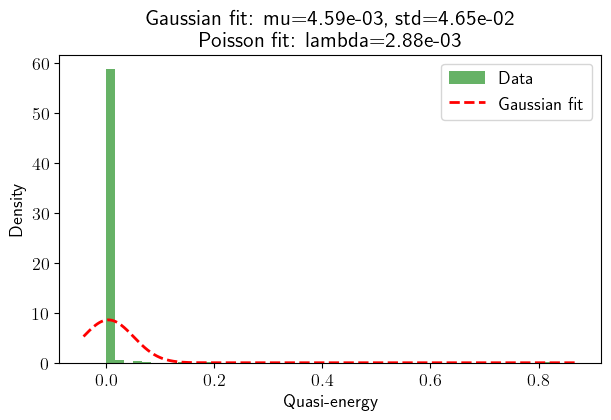

In [99]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, poisson

# Histogram data
data = energies_1_pos

# Fit Gaussian (Normal) distribution
mu, std = norm.fit(data)

# Fit Poisson distribution (Poisson is for integer data, so we round)
data_int = np.round(data[data < 20])  # restrict to reasonable range for Poisson
data_int = data_int[data_int >= 0]
lambda_poisson = np.mean(data_int)

# Plot histogram
plt.hist(data, bins=50, density=True, alpha=0.6, color='g', label='Data')

# Plot Gaussian fit
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 500)
p_gauss = norm.pdf(x, mu, std)
plt.plot(x, p_gauss, 'r--', linewidth=2, label='Gaussian fit')

# Plot Poisson fit (only for integer x)
x_pois = np.arange(int(xmin), int(xmax))
p_pois = poisson.pmf(x_pois, lambda_poisson)
# Only plot Poisson fit if x_pois is not empty
if len(x_pois) > 0 and len(p_pois) > 0:
    plt.stem(x_pois, p_pois, 'b', markerfmt='bo', basefmt=" ", label='Poisson fit', use_line_collection=True)

plt.xlabel('Quasi-energy')
plt.ylabel('Density')
plt.legend()
plt.title(f'Gaussian fit: mu={mu:.2e}, std={std:.2e}\nPoisson fit: lambda={lambda_poisson:.2e}')
plt.show()